In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from pandas import set_option
# set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

###### Import packages needed for the make_vars functions
from scipy.interpolate import interp1d
import pywt

filename = 'data/facies_vectors.csv'
training_data = pd.read_csv(filename)
training_data.head()

Facies Formation  Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND  \
0       3     A1 SH  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915   
1       3     A1 SH  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565   
2       3     A1 SH  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050   
3       3     A1 SH  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115   
4       3     A1 SH  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300   

    PE  NM_M  RELPOS  
0  4.6     1   1.000  
1  4.1     1   0.979  
2  3.6     1   0.957  
3  3.5     1   0.936  
4  3.4     1   0.915

In [2]:
def make_dwt_vars_cD(wells_df,logs,levels,wavelet):

    wave= pywt.Wavelet(wavelet)
    max_level = max(levels)
    
    grouped = wells_df.groupby(['Well Name'])
    new_df = pd.DataFrame()
    for key in grouped.groups.keys():
    
        depth = grouped.get_group(key)['Depth']
        temp_df = pd.DataFrame()
        temp_df['Depth'] = depth
        for log in logs:
      
            temp_data = grouped.get_group(key)[log]

            cA_4, cD_4, cD_3, cD_2, cD_1 = pywt.wavedec(temp_data,wave,level=4,mode='symmetric')
            dict_cD_levels = {1:cD_1, 2:cD_2, 3:cD_3, 4:cD_4}
            #new_depth = np.linspace(min(depth),max(depth),len(cD))
            #fD = interp1d(new_depth,cD,kind='nearest')
                
            for i in levels:
                new_depth = np.linspace(min(depth),max(depth),len(dict_cD_levels[i]))
                fA = interp1d(new_depth,dict_cD_levels[i],kind='nearest')
                #temp_df[log + '_cD_step_level_' + str(i)] = fD(depth)
                temp_df[log + '_cD_level_' + str(i)] = fA(depth)
    
        temp_df['Well Name'] = [key for _ in range(len(depth))]
        new_df = new_df.append(temp_df)
        
    new_df = new_df.sort_index()
    new_df = new_df.drop(['Well Name','Depth'],axis=1)
    wells_df = wells_df[['Facies', 'Formation', 'Well Name', 'Depth']]
    return pd.concat([wells_df, new_df],axis=1)

In [3]:
##### cD From wavelet db1
dwt_db3_cD_df = make_dwt_vars_cD(wells_df=training_data, logs=['GR', 'ILD_log10', 'DeltaPHI', 'PE', 'PHIND'],
                       levels=[1, 2, 3, 4], wavelet='db3')
print (dwt_db3_cD_df.shape)
dwt_db3_cD_df.head(5)

(4149, 24)


Facies Formation  Well Name   Depth  GR_cD_level_1  GR_cD_level_2  \
0       3     A1 SH  SHRIMPLIN  2793.0       0.062591       1.705360   
1       3     A1 SH  SHRIMPLIN  2793.5      -1.930541       1.705360   
2       3     A1 SH  SHRIMPLIN  2794.0      -1.930541      -2.389276   
3       3     A1 SH  SHRIMPLIN  2794.5      -5.282836      -2.389276   
4       3     A1 SH  SHRIMPLIN  2795.0      -5.282836      -2.389276   

   GR_cD_level_3  GR_cD_level_4  ILD_log10_cD_level_1  ILD_log10_cD_level_2  \
0      -1.990511        0.61415              0.000573             -0.003762   
1      -1.990511        0.61415             -0.000573             -0.003762   
2      -1.990511        0.61415             -0.000573              0.001721   
3      -1.990511        0.61415              0.000290              0.001721   
4      -2.914868        0.61415              0.000290              0.001721   

         ...         DeltaPHI_cD_level_3  DeltaPHI_cD_level_4  PE_cD_level_1  \
0        ...                   -2.126415             0.920055       0.109651   
1        ...                   -2.126415             0.920055      -0.228628   
2        ...                   -2.126415             0.920055      -0.228628   
3        ...                   -2.126415             0.920055      -0.037444   
4        ...                   -3.097360             0.920055      -0.037444   

   PE_cD_level_2  PE_cD_level_3  PE_cD_level_4  PHIND_cD_level_1  \
0      -0.580157       0.469831      -0.200765         -0.164746   
1      -0.580157       0.469831      -0.200765          0.240594   
2       0.102001       0.469831      -0.200765          0.240594   
3       0.102001       0.469831      -0.200765         -0.021035   
4       0.102001       0.997111      -0.200765         -0.021035   

   PHIND_cD_level_2  PHIND_cD_level_3  PHIND_cD_level_4  
0          0.662663         -0.533086          0.233332  
1          0.662663         -0.533086          0.233332  
2         -0.012342         -0.533086          0.233332  
3         -0.012342         -0.533086          0.233332  
4         -0.012342         -1.061813          0.233332  

[5 rows x 24 columns]

In [4]:
####### Creating dictionary of colours for the different facies
facies_colors = {1:'#F4D03F', 2:'#F5B041',3:'#DC7633',4:'#6E2C00',
       5:'#1B4F72',6:'#2E86C1', 7:'#AED6F1', 8:'#A569BD', 9:'#196F3D'}
facies_name = {1:'SS', 2:'CSiS',3:'FSiS',4:'SiSh', 5:'MS',6:'WS', 7:'D', 8:'PS', 9:'BS'}

flatui = ['#F4D03F', '#F5B041', '#DC7633', '#6E2C00',
       '#1B4F72', '#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

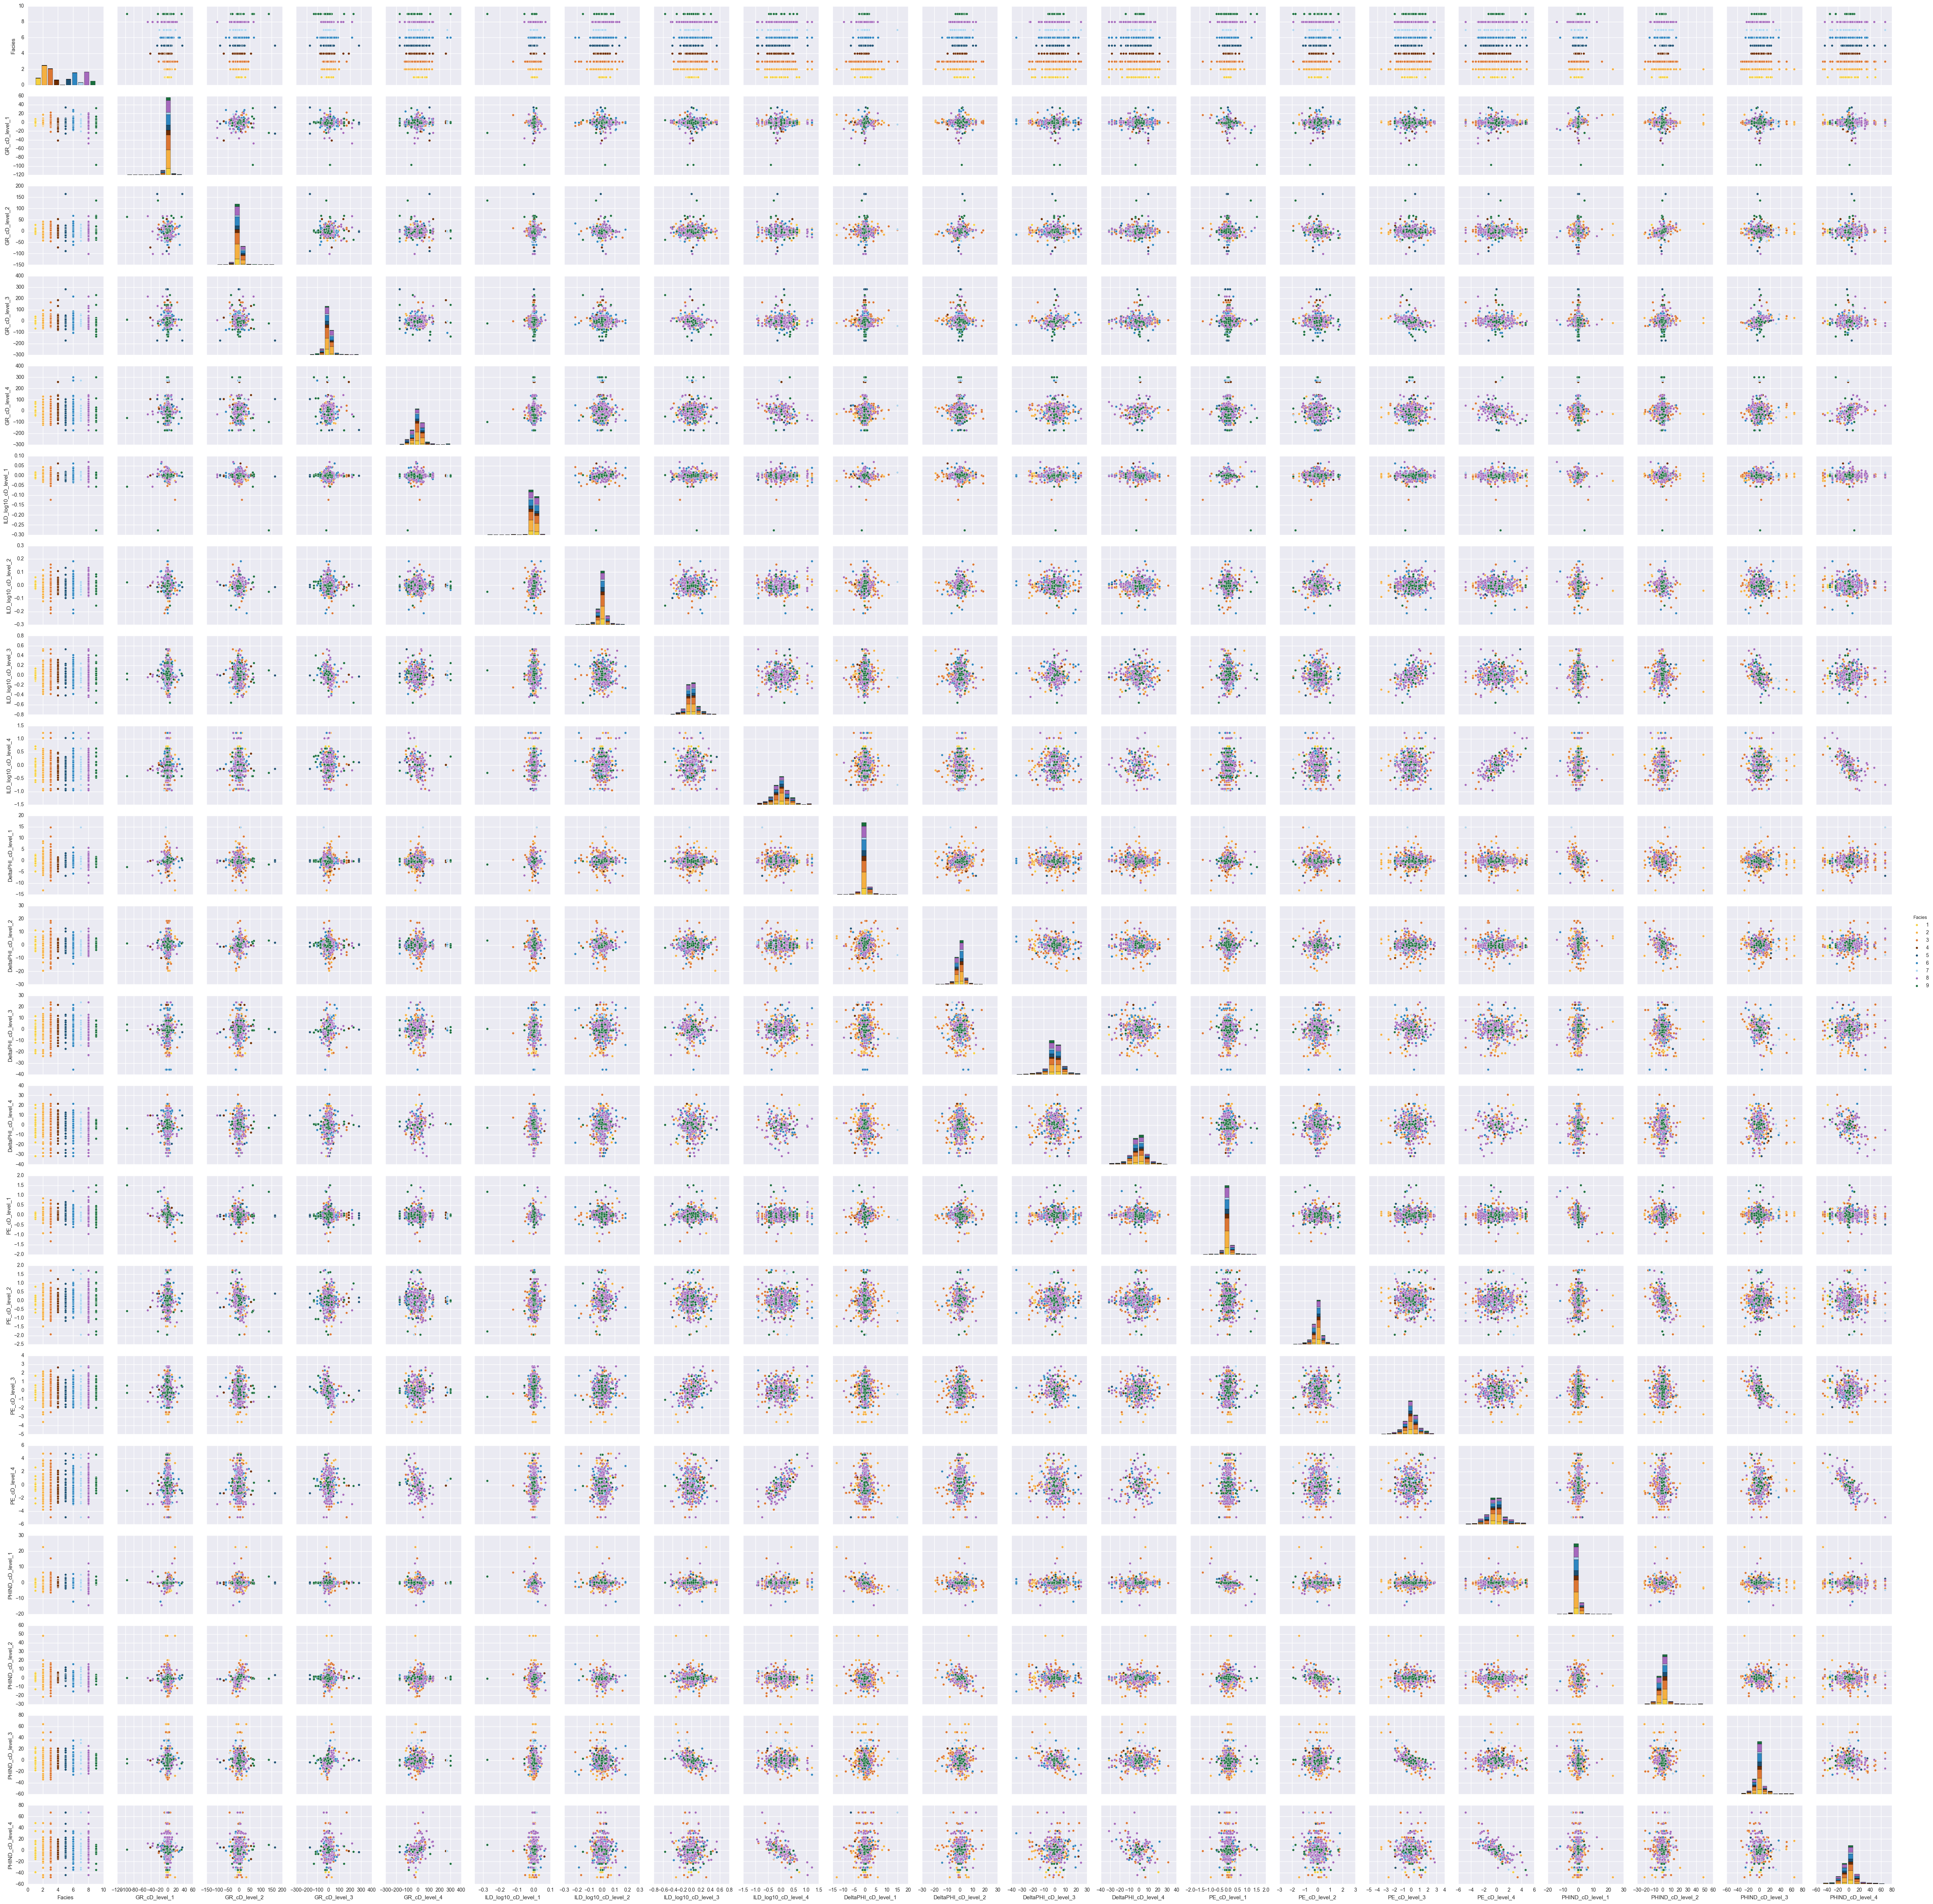

In [6]:
sns.set()
temp_df = dwt_db3_cD_df
temp_df = temp_df.drop(['Formation', 'Well Name', 'Depth'], axis=1)
temp_df.dropna(inplace=True)
sns.pairplot(temp_df, hue='Facies', palette = flatui)

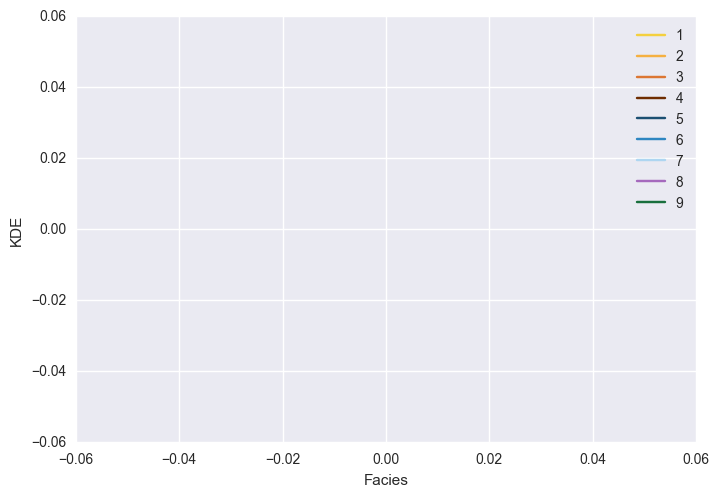

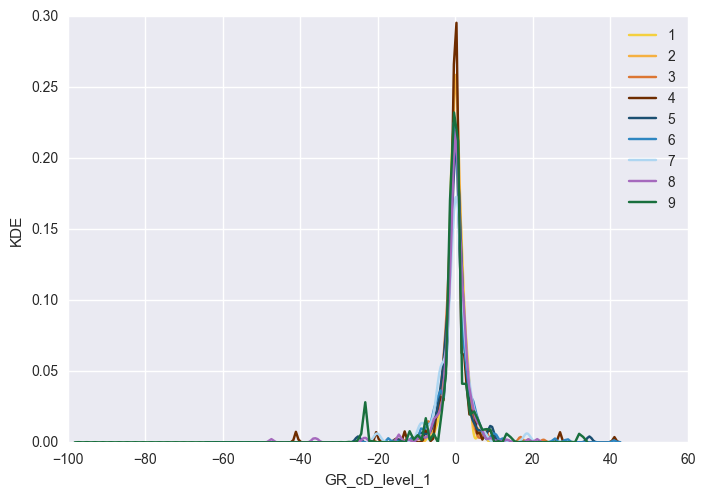

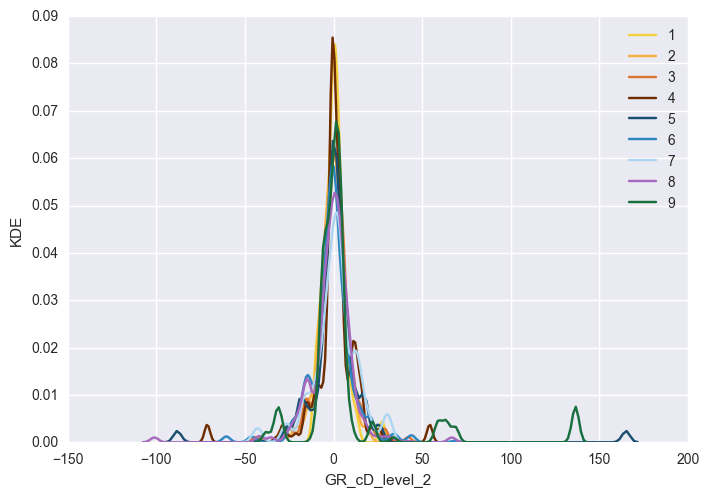

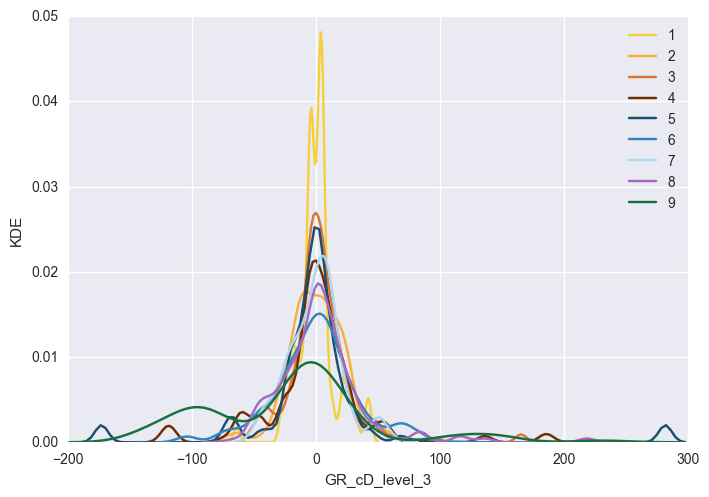

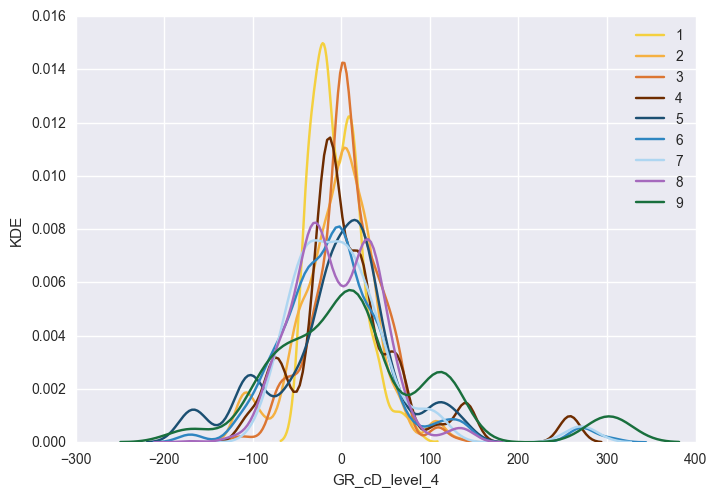

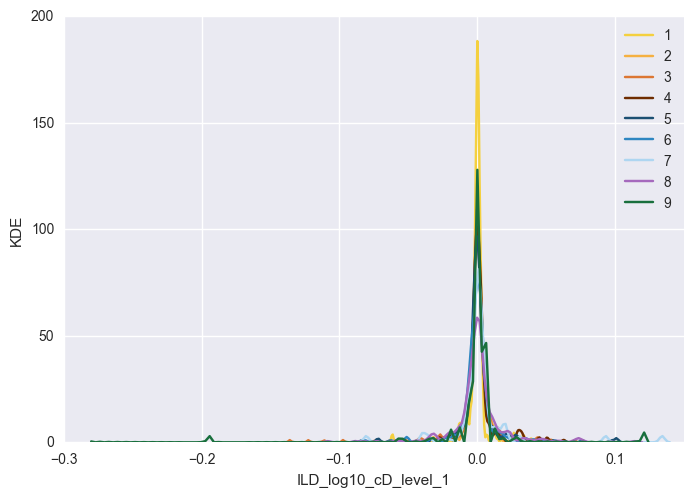

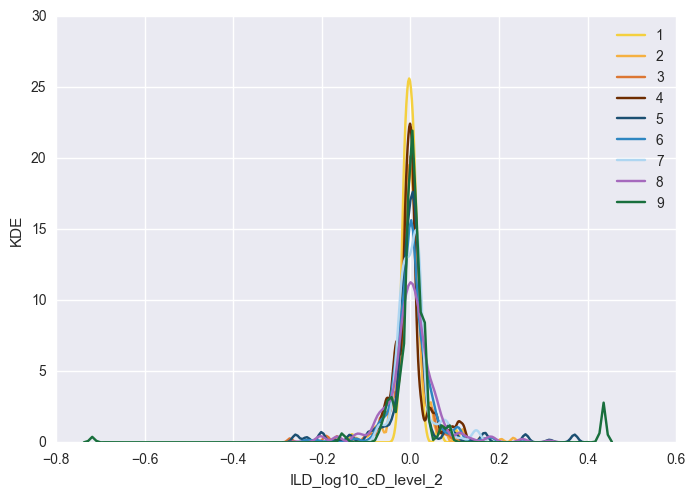

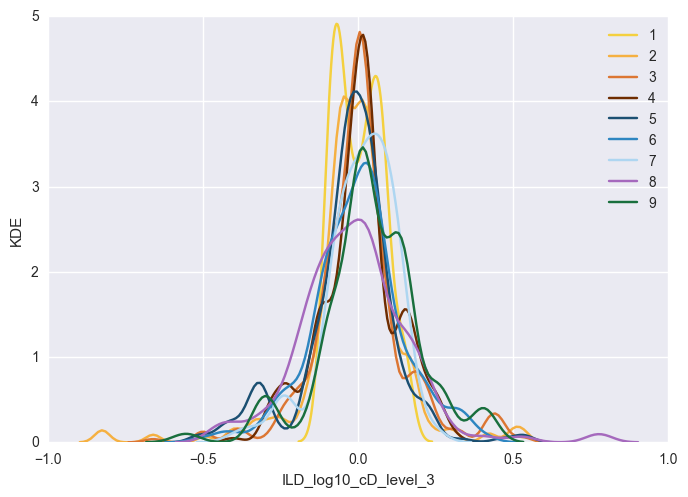

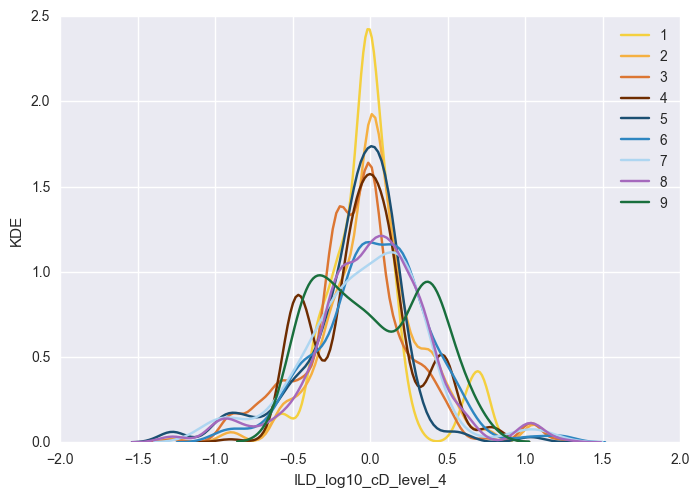

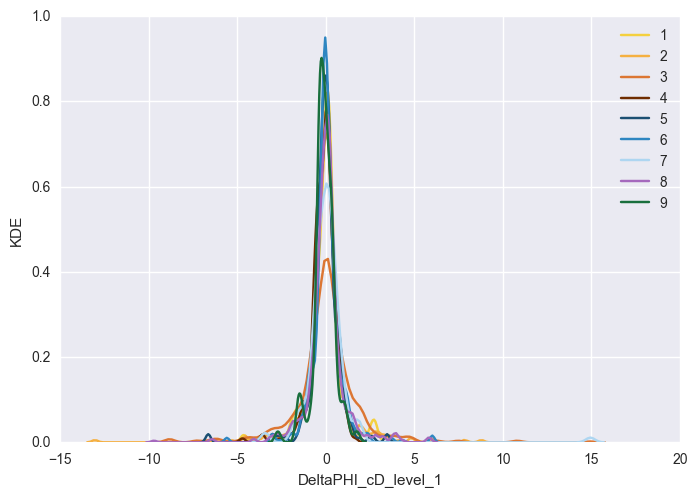

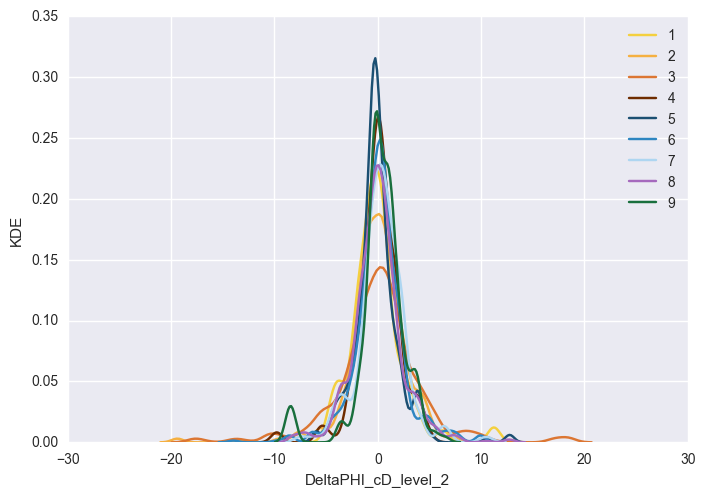

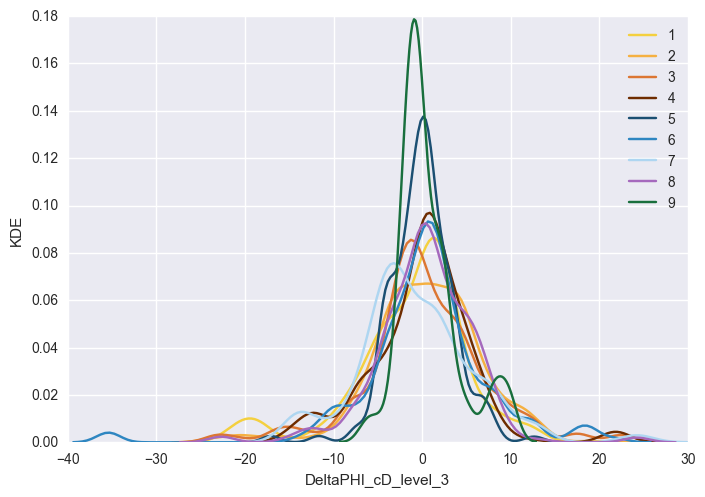

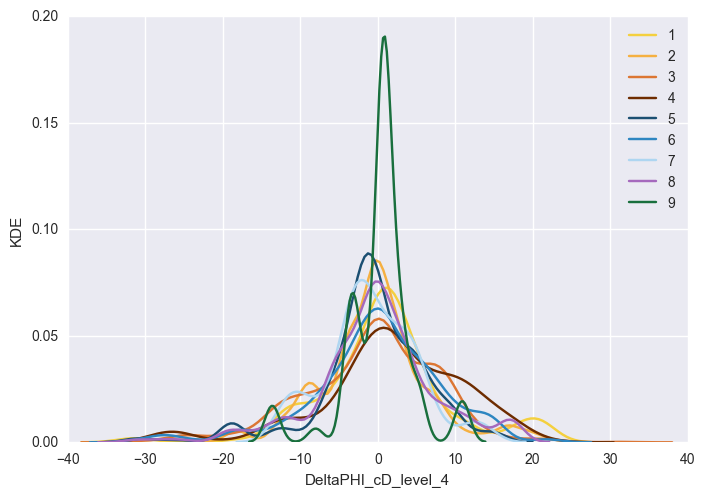

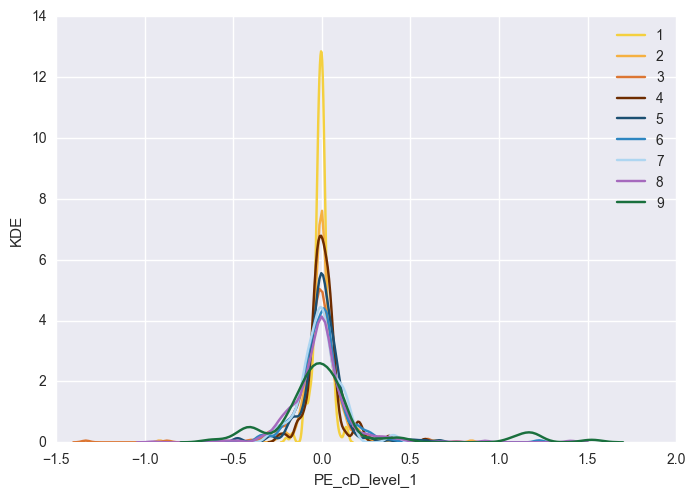

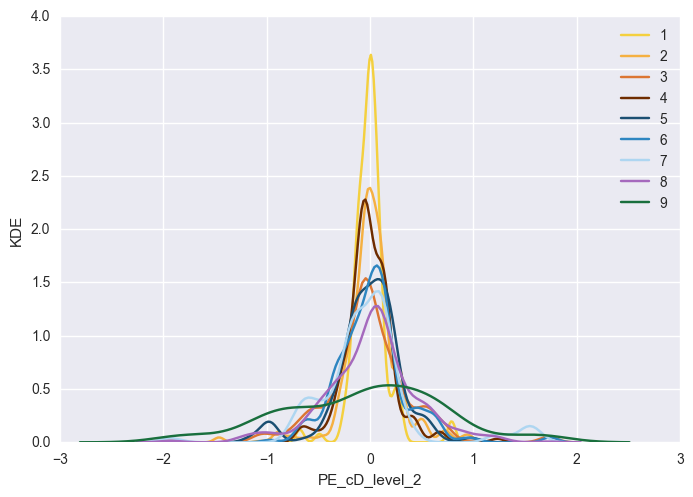

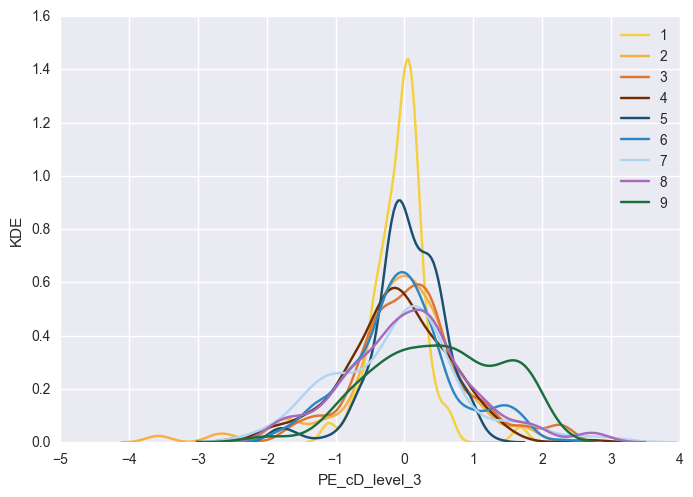

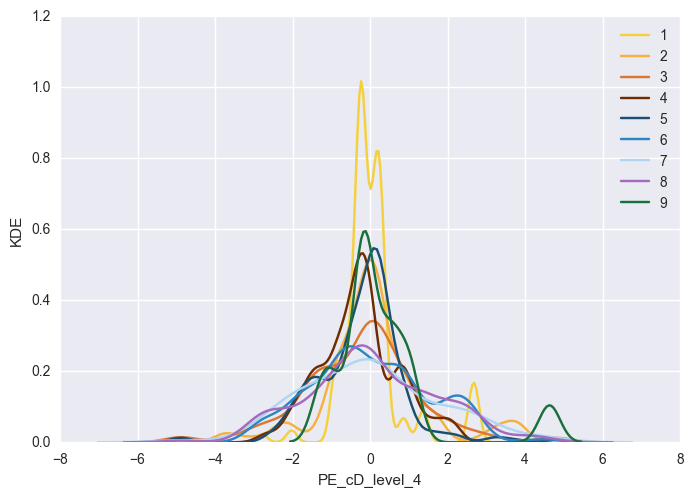

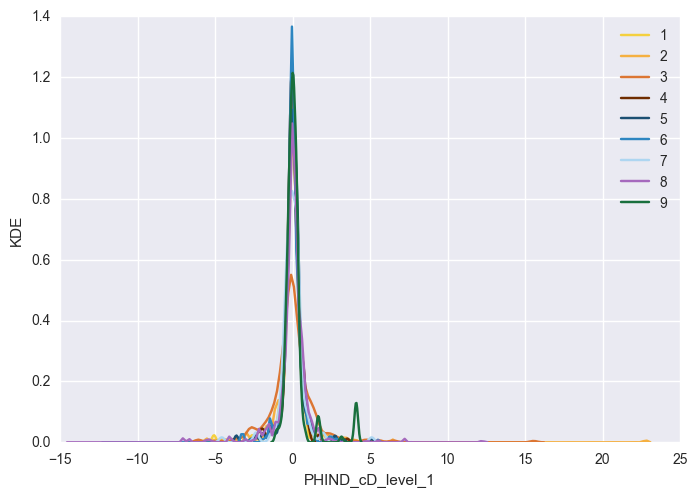

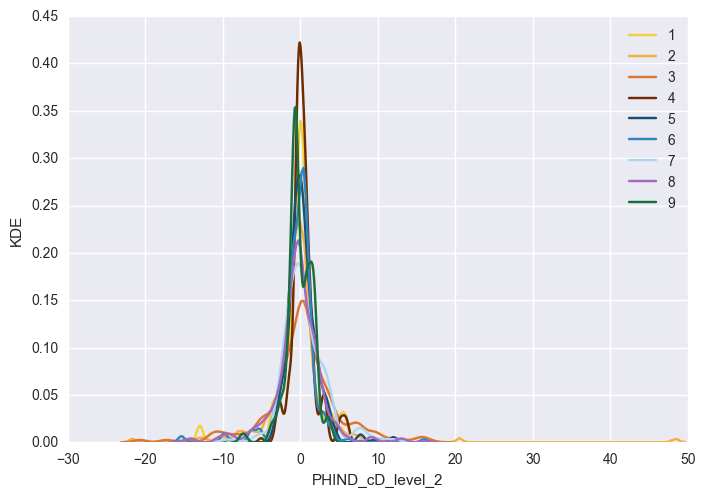

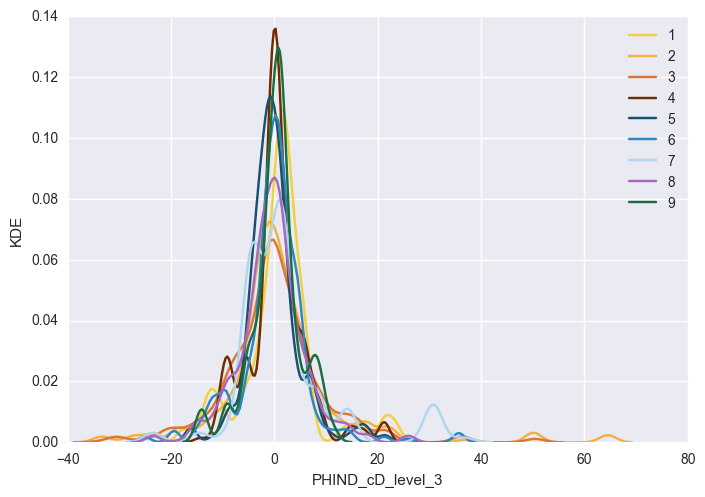

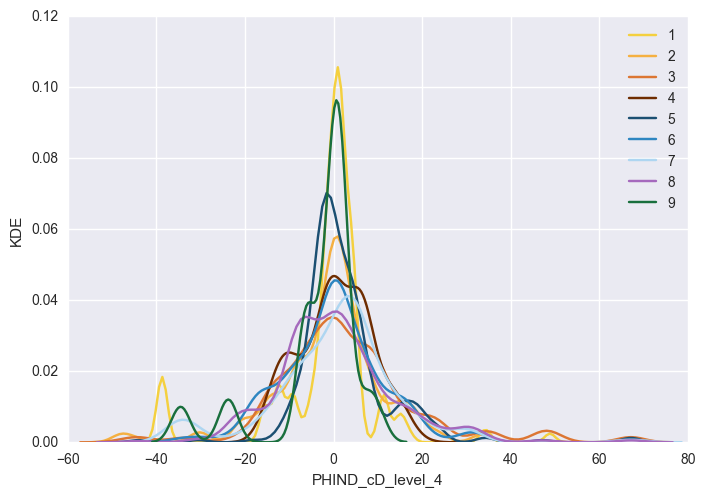

In [7]:
sns.set_palette(flatui)
list_variables = list(dwt_db3_cD_df.columns.values)
list_variables.remove('Formation')
list_variables.remove('Well Name')
list_variables.remove('Depth')
#list_variables = ['GR_cD_step_level_1', 'GR_cA_step_level_1', 'GR_cD_step_level_2', 'GR_cA_step_level_2', 'GR_cD_step_level_3', 'GR_cA_step_level_3']
for a in list_variables:
    for i in np.arange(1, 10, 1):
        sns.kdeplot(dwt_db3_cD_df[a][dwt_db3_cD_df['Facies'] == i], label=i)
    plt.xlabel(a)
    plt.ylabel('KDE')
    plt.show()